
=== Training Scores ===
Train Accuracy: 0.8266
Train ROC AUC:  0.9034

=== Cross-Validation Scores ===
CV Accuracy: 0.8344 ± 0.0151
CV ROC AUC:  0.8941 ± 0.0298

=== Final Evaluation (Test Set) ===
Accuracy:      0.8875
ROC AUC:       0.9221
Best Threshold:0.6304
F1 Score:      0.7857

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       123
           1       0.70      0.89      0.79        37

    accuracy                           0.89       160
   macro avg       0.83      0.89      0.85       160
weighted avg       0.90      0.89      0.89       160



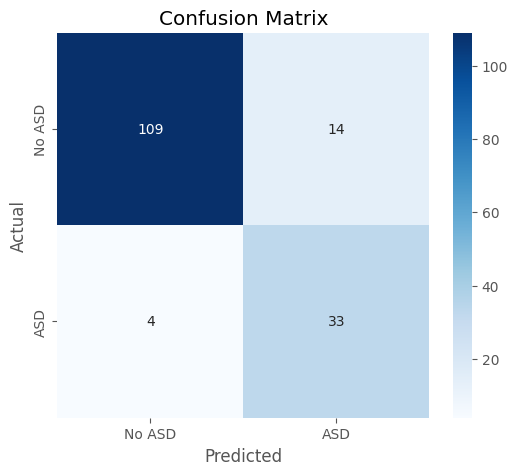

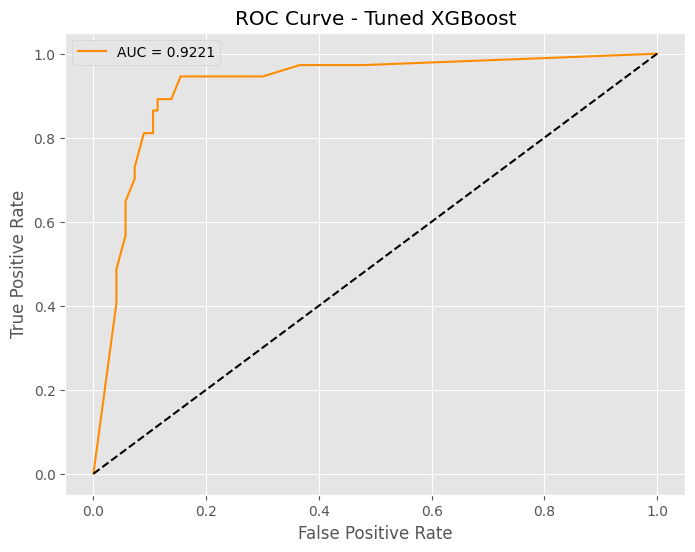

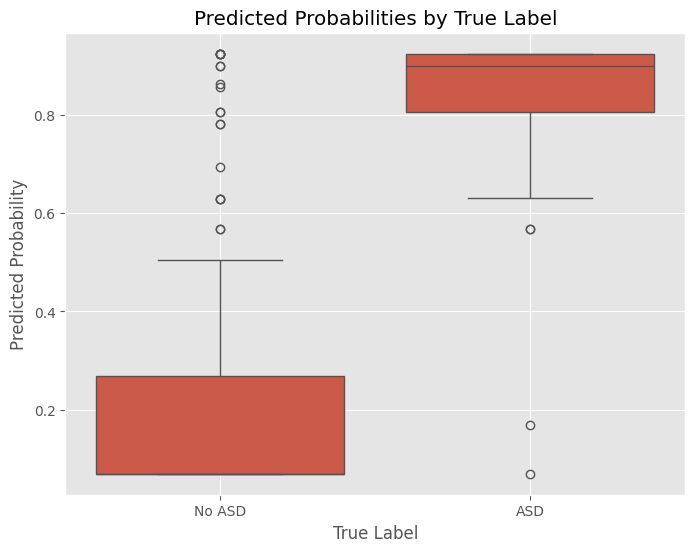


Test predictions saved to 'xgboost_predictions.csv'


In [31]:
# ===============================
#         IMPORTS
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, roc_curve, precision_recall_curve, f1_score)
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

# ===============================
#         LOAD DATA
# ===============================
train_data = pd.read_csv('Autism-prediction/train (1).csv')
test_data = pd.read_csv('Autism-prediction/test.csv')

# ===============================
#      BASIC CLEANING
# ===============================
for col in ['ethnicity', 'contry_of_res', 'relation']:
    train_data[col] = train_data[col].fillna('Unknown').replace('?', 'Unknown')
    test_data[col] = test_data[col].fillna('Unknown').replace('?', 'Unknown')

# Remove unused columns
excluded_cols = ['ID', 'Class/ASD', 'ethnicity', 'jaundice', 'austim', 
                 'contry_of_res', 'used_app_before', 'age_desc', 'relation', 'gender']
target_col = 'Class/ASD'

# ===============================
#  FEATURE ENGINEERING (ENHANCED)
# ===============================
aq_cols = [f'A{i}_Score' for i in range(1, 11)]
train_data['AQ_Total'] = train_data[aq_cols].sum(axis=1)
test_data['AQ_Total'] = test_data[aq_cols].sum(axis=1)
train_data['AQ_Mean'] = train_data[aq_cols].mean(axis=1)
test_data['AQ_Mean'] = test_data[aq_cols].mean(axis=1)
train_data['AQ_Std'] = train_data[aq_cols].std(axis=1).fillna(0)
test_data['AQ_Std'] = test_data[aq_cols].std(axis=1).fillna(0)
train_data['Result_Log'] = np.log1p(train_data['result'])
test_data['Result_Log'] = np.log1p(test_data['result'])
train_data['AQ_Result_Ratio'] = train_data['AQ_Total'] / (train_data['result'] + 0.1)
test_data['AQ_Result_Ratio'] = test_data['AQ_Total'] / (test_data['result'] + 0.1)
train_data['Age_Sq'] = train_data['age'] ** 2
test_data['Age_Sq'] = test_data['age'] ** 2
train_data['Family_Autism'] = (train_data['austim'] == 'yes').astype(int)
test_data['Family_Autism'] = (test_data['austim'] == 'yes').astype(int)
train_data['Had_Jaundice'] = (train_data['jaundice'] == 'yes').astype(int)
test_data['Had_Jaundice'] = (test_data['jaundice'] == 'yes').astype(int)

# ===============================
#  LABEL ENCODING (Train & Test)
# ===============================
cat_cols = ['relation', 'ethnicity', 'contry_of_res', 'gender']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_data[col], test_data[col]], axis=0).astype(str)
    le.fit(combined)
    train_data[col] = le.transform(train_data[col].astype(str))
    test_data[col] = le.transform(test_data[col].astype(str))
    le_dict[col] = le

# ===============================
#      FINAL FEATURE SETUP
# ===============================
features = [col for col in train_data.columns if col not in excluded_cols]
X_all = train_data[features]
y_all = train_data[target_col]
X_final_test = test_data[features]

# ===============================
#  TRAIN-TEST SPLIT
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

# ===============================
#  FINAL MODEL WITH FIXED PARAMS
# ===============================
final_params = {
    'max_depth': 7,
    'learning_rate': 0.01001899609851384,
    'n_estimators': 295,
    'subsample': 0.5702375585625796,
    'colsample_bytree': 0.6054947184363908,
    'reg_alpha': 3.647524638543568,
    'reg_lambda': 1.593578453887627,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

model = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('sampler', SMOTEENN(random_state=42)),
    ('scaler', RobustScaler()),
    ('feature_sel', SelectFromModel(XGBClassifier(**final_params, importance_type='gain'))),
    ('xgb', XGBClassifier(**final_params))
])

# ===============================
#   TRAIN, CV AND TEST EVAL
# ===============================
model.fit(X_train, y_train)

# Training Eval
train_probs = model.predict_proba(X_train)[:, 1]
train_preds = model.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)
train_auc = roc_auc_score(y_train, train_probs)

# Cross-Validation Eval
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=skf)
cv_auc_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=skf)

# Test Eval
y_prob = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred = (y_prob >= best_threshold).astype(int)

print("\n=== Training Scores ===")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Train ROC AUC:  {train_auc:.4f}")

print("\n=== Cross-Validation Scores ===")
print(f"CV Accuracy: {cv_acc_scores.mean():.4f} ± {cv_acc_scores.std():.4f}")
print(f"CV ROC AUC:  {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}")

print("\n=== Final Evaluation (Test Set) ===")
print(f"Accuracy:      {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC:       {roc_auc_score(y_test, y_prob):.4f}")
print(f"Best Threshold:{best_threshold:.4f}")
print(f"F1 Score:      {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No ASD', 'ASD'], yticklabels=['No ASD', 'ASD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned XGBoost')
plt.legend()
plt.grid(True)
plt.show()

# Boxplot of Probabilities
prob_df = pd.DataFrame({'True Label': y_test, 'Predicted Probability': y_prob})
plt.figure(figsize=(8, 6))
sns.boxplot(x='True Label', y='Predicted Probability', data=prob_df)
plt.title('Predicted Probabilities by True Label')
plt.xticks([0, 1], ['No ASD', 'ASD'])
plt.grid(True)
plt.show()

# ===============================
# EXPORT PREDICTIONS TO CSV
# ===============================
xgb_test_probs = model.predict_proba(X_final_test)[:, 1]
xgb_test_preds = (xgb_test_probs >= best_threshold).astype(int)
submission_df = test_data[['ID']].copy()
submission_df['Predicted_Probability'] = xgb_test_probs
submission_df['Predicted_Label'] = xgb_test_preds
submission_df.to_csv('xgboost_predictions.csv', index=False)
print("\nTest predictions saved to 'xgboost_predictions.csv'")
